## 1. 定义算法
强化学习算法的模式都比较固定，一般包括 sample（即训练时采样动作），predict（测试时预测动作），update（算法更新）以及保存模型和加载模型等几个方法，其中对于每种算法 sample 和 update 的方式是不相同，而其他方法就大同小异。

In [1]:
import numpy as np
import math
from collections import defaultdict


class Q_learning:
    """ Q-learning 算法实现类"""

    def __init__(self,  n_actions, cfg):
        """
        初始化 Q-learning 算法
        
        参数:
        n_states: 状态空间大小
        n_actions: 动作空间大小
        cfg: 配置参数
        """
        self.n_actions = n_actions
        self.lr = cfg.lr  # 学习率
        self.sample_count = 0  # 采样次数
        self.gamma = cfg.gamma  # 折扣因子
        self.epsilon = cfg.epsilon_start  # 当前探索率
        self.epsilon_start = cfg.epsilon_start  # 初始探索率
        self.epsilon_end = cfg.epsilon_end  # 最终探索率
        self.epsilon_decay = cfg.epsilon_decay  # 探索率衰减速度
        self.Q_table = defaultdict(lambda: np.zeros(n_actions))  # Q表

    def sample(self, state):
        """
        使用ε-贪婪策略采样动作
        
        参数:
        state: 当前状态
        
        返回:
        action: 选择的动作
        """
        self.sample_count += 1
        # 更新探索率
        self.epsilon = self.epsilon_end + (
            self.epsilon_start - self.epsilon_end) * math.exp(
                -1 * self.sample_count / self.epsilon_decay)

        # ε-贪婪策略
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)])  # 选择最优动作
        else:
            action = np.random.choice(self.n_actions)  # 随机选择动作
        return action

    def predict(self, state):
        """
        预测最优动作（用于测试）
        
        参数:
        state: 当前状态
        
        返回:
        action: 预测的最优动作
        """
        action = np.argmax(self.Q_table[str(state)])
        return action  # 添加返回语句

    def update(self, state, action, reward, next_state, terminated):
        """
        更新Q表
        
        参数:
        state: 当前状态
        action: 执行的动作
        reward: 获得的奖励
        next_state: 下一个状态
        terminated: 是否终止
        """
        Q_predict = self.Q_table[str(state)][action]

        if terminated:
            Q_target = reward
        else:
            Q_target = reward + self.gamma * np.max(
                self.Q_table[str(next_state)])

        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict
                                                       )  # 修正更新公式


## 2. 定义训练
强化学习算法的训练方式也比较固定，如下：
```python
for i_ep in range(train_eps): # 遍历每个回合
    state = env.reset()  # 重置环境,即开始新的回合
    while True: # 对于一些比较复杂的游戏可以设置每回合最大的步长，例如while ep_step<100，就是每回合最大步长为100。
        action = agent.sample(state)  # 根据算法采样一个动作
        next_state, reward, terminated, _ = env.step(action)  # 与环境进行一次动作交互
        agent.memory.push(state, action, reward, next_state, terminated) # 记录memory
        agent.update(state, action, reward, next_state, terminated)  # 算法更新
        state = next_state  # 更新状态
        if terminated:
            break
```
首先对于每个回合，回合开始时环境需要重置，好比我们每次开一把游戏需要从头再来一样。我们可以设置智能体在每回合数的最大步长，尤其是对于比较复杂的游戏，这样做的好处之一就是帮助智能体在训练中快速收敛，比如我们先验地知道最优解的大概步数，那么理论上智能体收敛时也应该是这个步数附近，设置最大步数可以方便智能体接近这个最优解。在每个回合中，智能体首先需要采样（sample），或者说采用探索策略例如常见的 $\varepsilon$-greedy 策略或者 UCB 探索策略等等。采样的过程是将当前的状态 state 作为输入，智能体采样输出动作action。然后环境根据采样出来的动作反馈出下一个状态以及相应的 reward 等信息。接下来对于具有 memory 的智能体例如包含 replay memory 的 DQN 来说，需要将相应的 transition（记住这个词，中文不好翻译，通常是状态、动作、奖励等信息）。紧接着就是智能体更新，对于深度强化学习此时一般从 memory 中随机采样一些 transition 进行更新，对于 Q-learning 一般是采样上一次的 transition。更新公式是比较关键的部分，但是也很通用，一般基于值的算法更新公式都是一个套路如下：
$$
y_{j}= \begin{cases}r_{j} & \text { for terminal } s_{t+1} \\ r_{j}+\gamma \max _{a^{\prime}} Q\left(s_{t+1}, a^{\prime} ; \theta\right) & \text { for non-terminal } s_{t+1}\end{cases}
$$
智能体更新完之后，通常需要更新状态，即 ```state = next_state```，然后会检查是否完成了这一回合的游戏，即 ```terminated==True``` ，注意完成并不代表这回合成功，也有可能是失败的太离谱，等同学们有了自定义强化学习环境的经验就知道了。
如果需要记录奖励、损失等等的话可以再加上，如下方代码，实际项目中更多地使用 tensorboard 来记录相应的数据，甚至于笔者就在这些教学代码中使用过，但是看起来有些繁琐，容易给大家增加不必要的学习难度，因此学有余力以及需要在项目研究中做强化学习的可以去看看，也很简单。
此外稍微复杂一些的强化学习不是一次性写完代码就能收敛的，这时需要我们做一个调参侠。为了检查我们参数调得好不好，可以在终端print出奖励、损失以及epsilon等随着回合数的变化，这点说明一下强化学习的训练过程一般都是先探索然后收敛的，官方的话就是权衡 exploration and exploitation。$\varepsilon$-greedy 策略的做法就是前期探索，然后逐渐减小探索率至慢慢收敛，也就是这个 epsilon。这个值越大比如 0.9 就说明智能体 90% 的概率在随机探索，通常情况下会设置三个值，epsilon_start、epsilon_end 以及 epsilon_decay，即初始值、终止值和衰减率，其中初始值一般是 0.95 不变，终止值是 0.01，也就是说即使在收敛阶段也让智能体保持很小概率的探索，这样做的原因就是智能体已经学出了一个不错的策略，但是保不齐还有更好的策略，好比我们知道要出人头地学历高比较重要，但是“人还是要有梦想的，万一实现了呢”，总是存在意外的可能，对吧。回归正题，比较关键的是 epsilon_decay 这个衰减率，这个 epsilon 衰减太快了学来的策略往往过拟合，好比一条只能选择一朵花的花道上，你早早选择了一朵看起来还可以的花，却错过了后面更多的好花。但是衰减的太慢会影响收敛的速度，好比你走过了花道的尽头也还没选出一朵花来，相比前者不如更甚。当然强化学习的调参相比于深度学习只能说是有过之无不及，比较复杂，不止 epsilon 这一个，这就需要同学们的耐心学习了。
强化学习测试的代码跟训练基本上是一样的，因此我放到同一个代码段里。相比于训练代码，测试代码主要有以下几点不同：
 1. 测试模型的过程是不需要更新的，这个是不言而喻的；
 2. 测试代码不需要采样（sample）动作，相比之代替的是预测（sample）动作，其区别就是采样动作时可能会使用各种策略例如 $\varepsilon$-greedy 策略，而预测动作不需要，只需要根据训练时学习好的Q表或者网络模型代入状态得到动作即可；
 3. 测试过程终端一般只需要看奖励，不需要看 epislon 等，反正它在测试中也是无意义的。

In [2]:
def train(cfg, env, agent):
    """
    训练智能体
    
    参数:
    cfg: 配置对象，包含训练参数如回合数等
    env: 强化学习环境
    agent: Q-learning智能体
    
    返回:
    dict: 包含训练过程中每个回合的累计奖励
    """
    print("开始训练！")
    print(f"环境：{cfg.env_name}，算法：{cfg.algo_name}")
    rewards = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        state = env.reset(seed=cfg.seed)
        while True:
            action = agent.sample(state)  # 采样动作
            next_state, reward, terminated, info = env.step(action)  # 与环境交互
            agent.update(state, action, reward, next_state, terminated)  # 更新Q表
            state = next_state
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        if (i_ep + 1) % 20 == 0:
            print(
                f"回合：{i_ep + 1} / {cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon:.3f}"
            )
    print("完成训练！")
    return {"rewards": rewards}


def test(cfg, env, agent):
    """
    测试智能体
    
    参数:
    cfg: 配置对象，包含测试参数如回合数等
    env: 强化学习环境
    agent: 训练好的Q-learning智能体
    
    返回:
    dict: 包含测试过程中每个回合的累计奖励
    """
    print("开始测试！")
    print(f"环境：{cfg.env_name}，算法：{cfg.algo_name}")
    rewards = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0
        state = env.reset(seed=cfg.seed)
        while True:
            action = agent.predict(state)  # 预测最优动作
            next_state, reward, terminated, info = env.step(action)  # 与环境交互
            state = next_state
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep + 1}，奖励：{ep_reward:.1f}")
    print("完成测试！")
    return {"rewards": rewards}

## 3、定义环境

OpenAI Gym 中其实集成了很多强化学习环境，足够大家学习了，但是在做强化学习的应用中免不了要自己创建环境，比如在本项目中其实不太好找到 Q-learning 能学出来的环境，Q-learning 实在是太弱了，需要足够简单的环境才行，因此本项目写了一个环境，大家感兴趣的话可以看一下，一般环境接口最关键的部分即是 reset 和 step。

In [3]:
import gym
import turtle
import numpy as np


class CliffWalkingWapper(gym.Wrapper):
    """
    CliffWalking环境的包装器类，用于可视化渲染。
    """

    def __init__(self, env):
        """
        初始化CliffWalkingWapper。

        参数:
        env: 原始的CliffWalking环境
        """
        gym.Wrapper.__init__(self, env)
        self.t = None  # turtle对象，用于绘图
        self.unit = 50  # 网格单元的大小
        self.max_x = 12  # 环境的最大x坐标
        self.max_y = 4  # 环境的最大y坐标

    def draw_x_line(self, y, x0, x1, color='grey'):
        """
        绘制水平线。

        参数:
        y: 线的y坐标
        x0: 起始x坐标
        x1: 结束x坐标
        color: 线的颜色
        """
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        """
        绘制垂直线。

        参数:
        x: 线的x坐标
        y0: 起始y坐标
        y1: 结束y坐标
        color: 线的颜色
        """
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        """
        绘制一个方框。

        参数:
        x, y: 方框左下角的坐标
        fillcolor: 填充颜色
        line_color: 边框颜色
        """
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for _ in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        """
        移动玩家到指定位置。

        参数:
        x, y: 玩家的新坐标
        """
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        """
        渲染当前环境状态。
        """
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')

            # 绘制边界
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)

            # 绘制网格线
            for i in range(1, self.max_y):
                self.draw_x_line(y=i * self.unit,
                                 x0=0,
                                 x1=self.max_x * self.unit)

            for i in range(1, self.max_x):
                self.draw_y_line(x=i * self.unit,
                                 y0=0,
                                 y1=self.max_y * self.unit)

            # 绘制悬崖
            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')

            # 绘制目标
            self.draw_box(self.max_x - 1, 0, 'yellow')

            self.t.shape('turtle')

        # 更新玩家位置
        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - self.s // self.max_x
        self.move_player(x_pos, y_pos)

In [ ]:
import gym


def env_agent_config(cfg, seed=1):
    """配置环境和智能体
    
    Args:
        cfg: 配置对象,包含环境名称等参数
        seed: 随机种子,默认为1
        
    Returns:
        env: 游戏环境
        agent: Q-learning智能体
    """
    # 创建并包装环境
    env = gym.make(cfg.env_name, new_step_api=True)
    env = CliffWalkingWapper(env)

    # 获取状态空间和动作空间大小
    n_states = env.observation_space.n  # 状态空间大小
    n_actions = env.action_space.n  # 动作空间大小
    print(f"状态数：{n_states}，动作数：{n_actions}")
    # 创建Q-learning智能体
    agent = Q_learning(n_actions, cfg)
    return env, agent

## 4. 设置参数

到这里所有 Q-learning 模块就算完成了，下面需要设置一些参数，方便大家“炼丹”，其中默认的是笔者已经调好的～。另外为了定义了一个画图函数，用来描述奖励的变化。

In [5]:
import matplotlib.pylab as plt
import seaborn as sns


class Config:
    """配置类，用于存储 Q-Learning 算法的参数"""

    def __init__(self):
        self.env_name = "CliffWalking-v0"  # 环境名称
        self.algo_name = 'Q-Learning'  # 算法名称
        self.train_eps = 400  # 训练回合数
        self.test_eps = 20  # 测试回合数
        self.max_steps = 200  # 每回合最大步数
        self.epsilon_start = 0.95  # 初始探索率
        self.epsilon_end = 0.01  # 最终探索率
        self.epsilon_decay = 0.9  # 探索率衰减因子
        self.gamma = 0.9  # 折扣因子
        self.lr = 0.1  # 学习率
        self.seed = 1  # 随机种子


def smooth(data, weight=0.9):
    """
    对数据进行平滑处理
    
    参数:
    data: 原始数据列表
    weight: 平滑权重，默认为0.9
    
    返回:
    smoothed: 平滑后的数据列表
    """
    last = data[0]
    smoothed = []
    for point in data:
        smooth_val = last * weight + (1 - weight) * point
        smoothed.append(smooth_val)
        last = smooth_val
    return smoothed


def plot_rewards(rewards, title='learning curve'):
    """
    绘制奖励曲线
    
    参数:
    rewards: 奖励列表
    title: 图表标题，默认为'learning curve'
    """
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'
    sns.set_style('whitegrid')

    plt.figure(figsize=(10, 6))

    plt.title(f"{title}", fontsize=14, pad=15, fontfamily="Times New Roman")
    plt.xlim(0, len(rewards))
    plt.ylim(min(rewards) - 5, max(rewards) + 5)
    plt.xlabel('Episodes', fontsize=12, fontfamily='Times New Roman')
    plt.ylabel('Rewards', fontsize=12, fontfamily='Times New Roman')

    plt.plot(rewards, label="Original Rewards", alpha=0.6)
    plt.plot(smooth(rewards), label='Smoothed Rewards', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.legend(fontsize=10, framealpha=0.5, prop={"family": 'Times New Roman'})


## 5. 开始训练

到现在我们真的可以像海绵宝宝那样大声说出来“我准备好了！“，跟着注释来看下效果吧～。

c:\Code\Code_Practice\Reinforcement_Learning\Sarsa\.conda\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Code\Code_Practice\Reinforcement_Learning\Sarsa\.conda\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


开始训练！
环境：CliffWalking-v0，算法：Q-Learning
回合：20 / 400，奖励：-110.0，Epsilon：0.010
回合：40 / 400，奖励：-46.0，Epsilon：0.010
回合：60 / 400，奖励：-63.0，Epsilon：0.010
回合：80 / 400，奖励：-41.0，Epsilon：0.010
回合：100 / 400，奖励：-58.0，Epsilon：0.010
回合：120 / 400，奖励：-35.0，Epsilon：0.010
回合：140 / 400，奖励：-25.0，Epsilon：0.010
回合：160 / 400，奖励：-21.0，Epsilon：0.010
回合：180 / 400，奖励：-28.0，Epsilon：0.010
回合：200 / 400，奖励：-30.0，Epsilon：0.010
回合：220 / 400，奖励：-30.0，Epsilon：0.010
回合：240 / 400，奖励：-21.0，Epsilon：0.010
回合：260 / 400，奖励：-21.0，Epsilon：0.010
回合：280 / 400，奖励：-13.0，Epsilon：0.010
回合：300 / 400，奖励：-15.0，Epsilon：0.010
回合：320 / 400，奖励：-13.0，Epsilon：0.010
回合：340 / 400，奖励：-13.0，Epsilon：0.010
回合：360 / 400，奖励：-13.0，Epsilon：0.010
回合：380 / 400，奖励：-13.0，Epsilon：0.010
回合：400 / 400，奖励：-13.0，Epsilon：0.010
完成训练！
开始测试！
环境：CliffWalking-v0，算法：Q-Learning
回合：1，奖励：-13.0
回合：2，奖励：-13.0
回合：3，奖励：-13.0
回合：4，奖励：-13.0
回合：5，奖励：-13.0
回合：6，奖励：-13.0
回合：7，奖励：-13.0
回合：8，奖励：-13.0
回合：9，奖励：-13.0
回合：10，奖励：-13.0
回合：11，奖励：-13.0
回合：12，奖励：-13.0
回合：13，奖励：-13.0
回合：14，奖励：-13.

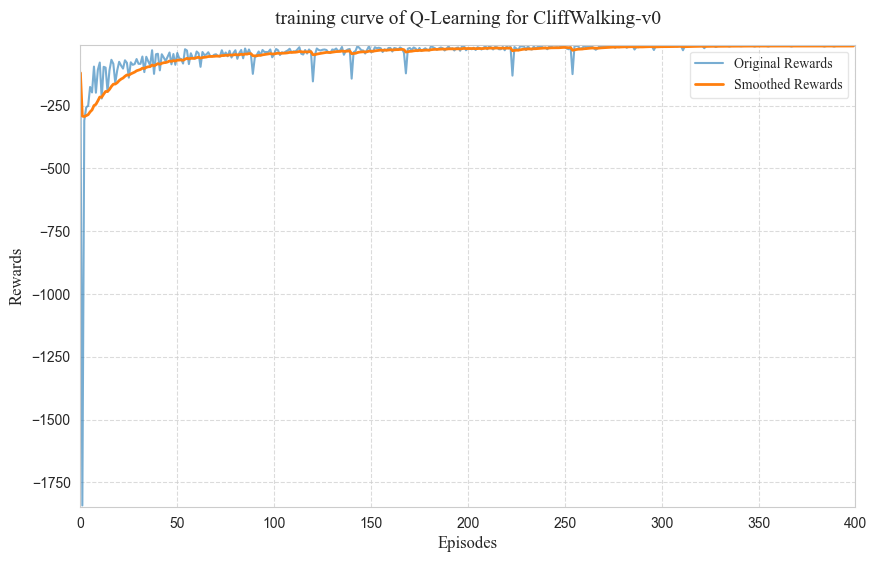

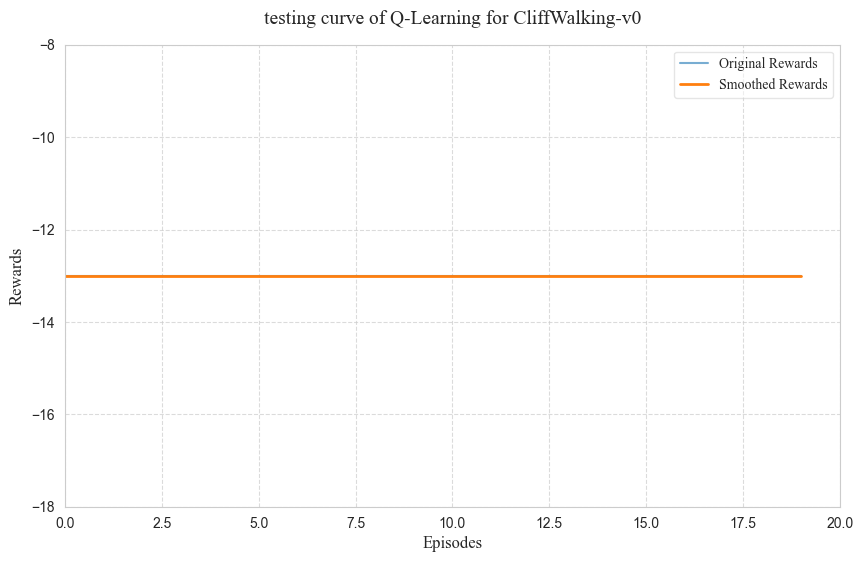

In [6]:
# 1. 初始化配置参数
cfg = Config() 

# 2. 训练阶段
# 2.1 配置环境和智能体
env, agent = env_agent_config(cfg)
# 2.2 开始训练并获取训练数据
res_dic = train(cfg, env, agent)
# 2.3 绘制训练过程的奖励曲线 
plot_rewards(res_dic['rewards'], title=f"training curve of {cfg.algo_name} for {cfg.env_name}")  

# 3. 测试阶段
# 3.1 使用训练好的智能体进行测试
res_dic = test(cfg, env, agent)
# 3.2 绘制测试过程的奖励曲线
plot_rewards(res_dic['rewards'], title=f"testing curve of {cfg.algo_name} for {cfg.env_name}")